In [5]:
import xarray as xr
import intake
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [1]:
path_precip = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.precip_radflx.nc"
path_wind = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10.nc"

In [6]:
data_precip = xr.open_dataset(path_precip)
data_wind = xr.open_dataset(path_wind)

In [7]:
data_wind

<xarray.Dataset> Size: 13GB
Dimensions:     (valid_time: 1029, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2025-09-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 16kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 4GB ...
    v10         (valid_time, latitude, longitude) float32 4GB ...
    t2m         (valid_time, latitude, longitude) float32 4GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-27T21:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [35]:
lat_boundary = [-32,-14]
long_boundary = [360-78,360-62]

#selecting the lat and long values in our dataset which we can then use to select data
lat_vals = data_wind["t2m"]["latitude"].values
long_vals = data_wind["t2m"]["longitude"].values
lat_vals = lat_vals[lat_vals>lat_boundary[0]]
lat_vals = lat_vals[lat_vals<lat_boundary[1]]

long_vals = long_vals[long_vals>long_boundary[0]]
long_vals = long_vals[long_vals<long_boundary[1]]
#long_vals

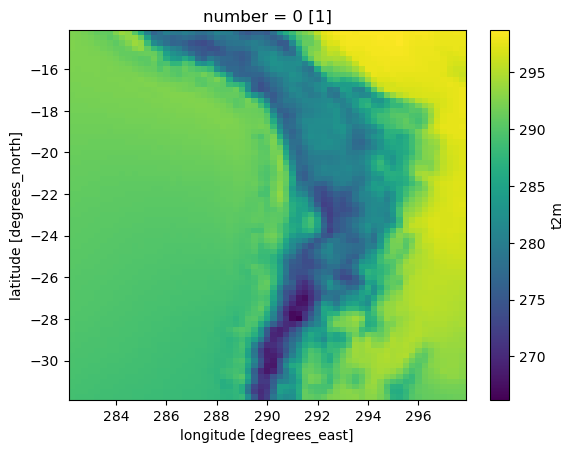

In [34]:
data_wind["t2m"].sel({"latitude":lat_vals,"longitude":long_vals}).mean("valid_time").plot()

In [31]:
data_wind["t2m"].sel({"latitude":lat_vals,"longitude":long_vals})

<xarray.DataArray 't2m' (valid_time: 1029, latitude: 71, longitude: 63)> Size: 18MB
[4602717 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2025-09-01
  * latitude    (latitude) float64 568B -14.25 -14.5 -14.75 ... -31.5 -31.75
  * longitude   (longitude) float64 504B 282.2 282.5 282.8 ... 297.2 297.5 297.8
    expver      (valid_time) <U4 16kB ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0